In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.2


In [2]:
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

Load Training Dataset

In [3]:
dataset = pd.read_csv('../input/training-dataset/Training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


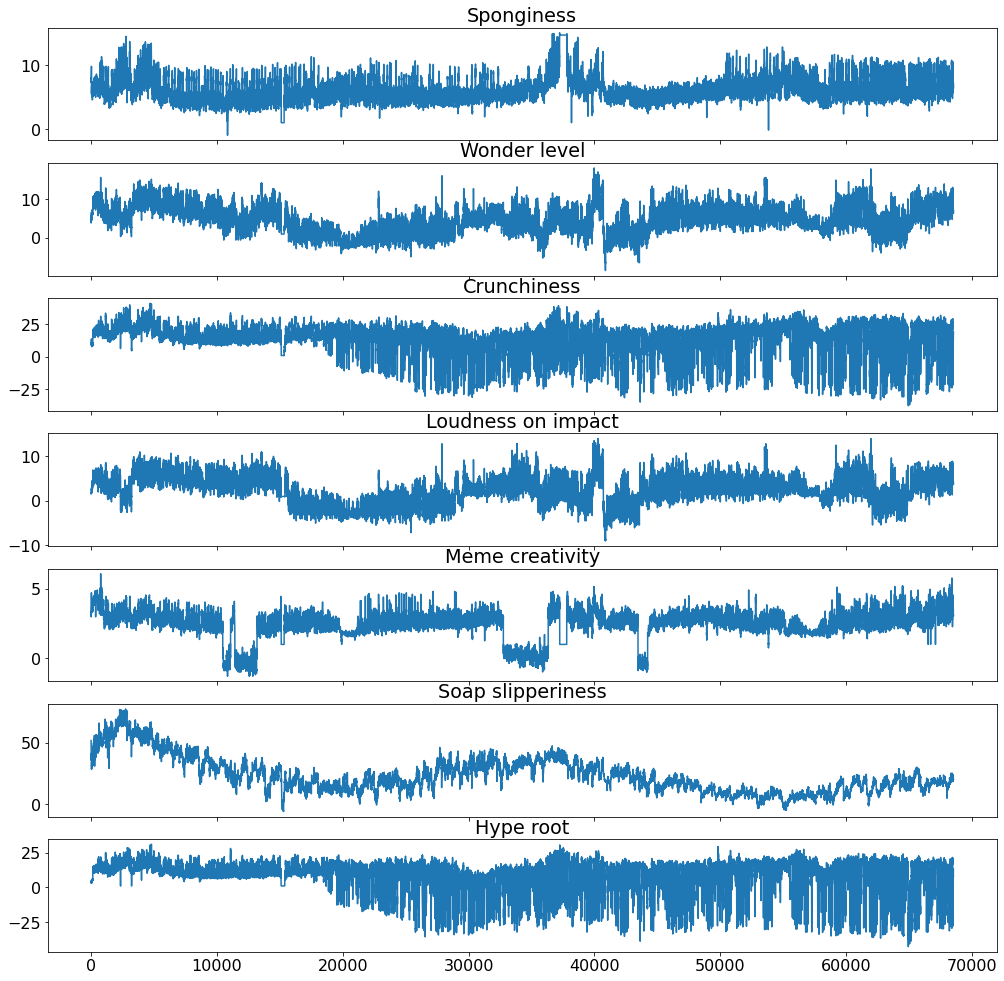

In [5]:
#plot training dataset
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

Augmented Dickey-Fuller Test (ADF Test)/unit root test

In [6]:
from statsmodels.tsa.stattools import adfuller
def adf_test(ts, signif=0.05):
    print(ts.name)
    dftest = adfuller(ts, autolag='AIC')
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    for key,value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    print (adf)
    
    p = adf['p-value']
    if p <= signif:
        print(f" Series is Stationary")
    else:
        print(f" Series is Non-Stationary")
#apply adf test on the series
for aspect in dataset.columns:
    adf_test(dataset[aspect])

Sponginess
Test Statistic         -1.616480e+01
p-value                 4.427228e-29
# Lags                  6.200000e+01
# Observations          6.846500e+04
Critical Value (1%)    -3.430446e+00
Critical Value (5%)    -2.861582e+00
Critical Value (10%)   -2.566792e+00
dtype: float64
 Series is Stationary
Wonder level
Test Statistic         -1.181717e+01
p-value                 8.583265e-22
# Lags                  5.800000e+01
# Observations          6.846900e+04
Critical Value (1%)    -3.430446e+00
Critical Value (5%)    -2.861582e+00
Critical Value (10%)   -2.566792e+00
dtype: float64
 Series is Stationary
Crunchiness
Test Statistic            -26.263997
p-value                     0.000000
# Lags                     62.000000
# Observations          68465.000000
Critical Value (1%)        -3.430446
Critical Value (5%)        -2.861582
Critical Value (10%)       -2.566792
dtype: float64
 Series is Stationary
Loudness on impact
Test Statistic         -1.134803e+01
p-value             

Split dataset in train-test and normalize the train and test set.

In [7]:
test_size = 1728
X_train_raw = dataset.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

(66800, 7) (1728, 7)


In [8]:
#check the correctness of the values chose for window and stride
#the function takes in input the normalized set, the sensors we want to predict, window, 
#stride and the number of samples we want to predict in the future
def build_sequences(df, target_labels, window, stride, telescope):
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [9]:
window = 200
stride = 10

In [10]:
future = dataset[-window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
future.shape

(1, 200, 7)

In [11]:
target_labels = dataset.columns

In [12]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

In [13]:
#build the model
def build_CONV_LSTM_model(input_shape, output_shape):
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    convlstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    convlstm = tfkl.Conv1D(256, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.GlobalAveragePooling1D()(convlstm)
    
    convlstm = tfkl.Dropout(.5)(convlstm)

    # we can use a Dense layer with a number given by telescope*num_channels,
    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    #obtain the dimension of [None, telescope, num_channels]
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    return model

In [14]:
target_labels = dataset.columns
telescope = 24

In [15]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_train_raw

((6658, 200, 7),
 (6658, 24, 7),
 (158, 200, 7),
 (158, 24, 7),
        Sponginess  Wonder level  Crunchiness  Loudness on impact  \
 0        0.556576      0.481134     0.612986            0.468044   
 1        0.562874      0.485320     0.611573            0.465453   
 2        0.559777      0.476949     0.611573            0.462934   
 3        0.559777      0.476949     0.611573            0.465453   
 4        0.550279      0.485320     0.610160            0.465453   
 ...           ...           ...          ...                 ...   
 66795    0.374251      0.476949     0.629940            0.491075   
 66796    0.367954      0.481134     0.637004            0.498704   
 66797    0.377349      0.481134     0.645481            0.501296   
 66798    0.374251      0.468578     0.644068            0.491075   
 66799    0.386847      0.476949     0.648307            0.493594   
 
        Meme creativity  Soap slipperiness  Hype root  
 0             0.613765           0.691885   0.629

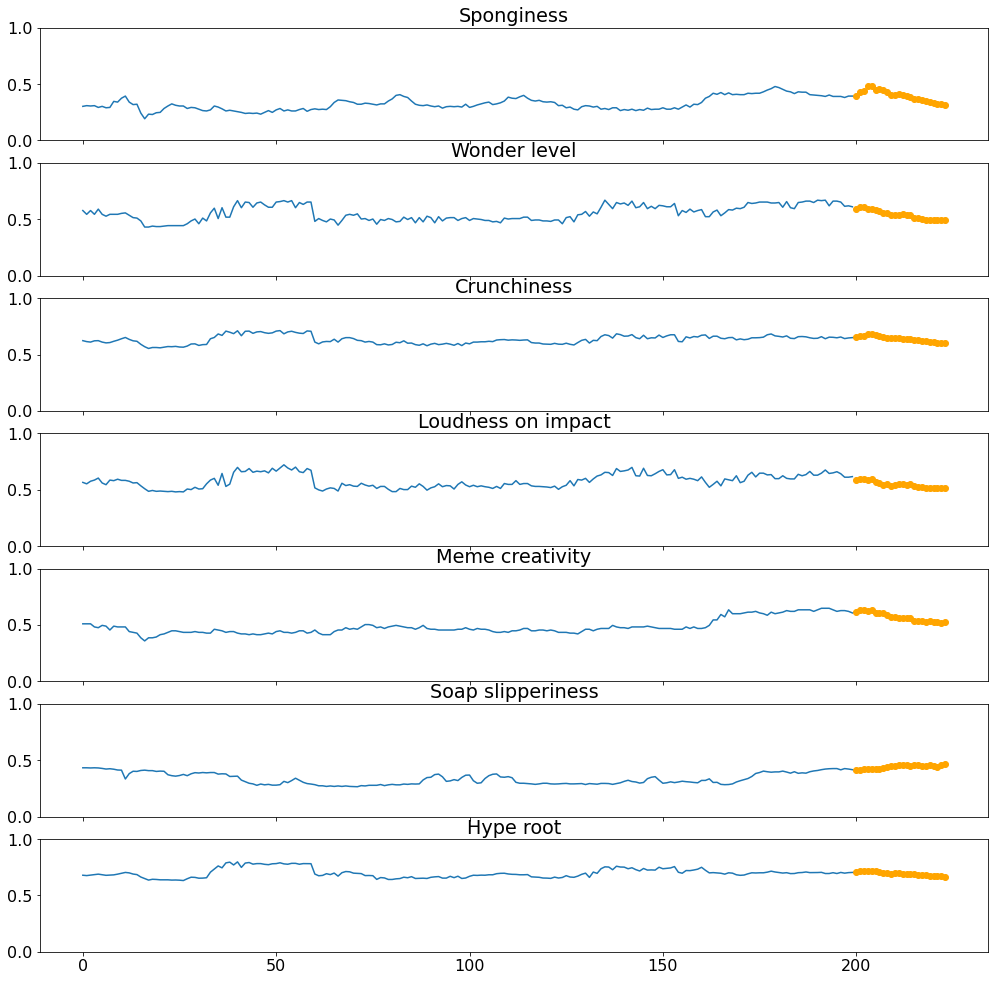

In [16]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [17]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 32
epochs = 200

2022-01-20 10:22:13.387120: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 10:22:13.534659: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 10:22:13.535822: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 10:22:13.537713: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 200, 7)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200, 256)          139264    
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 256)          196864    
_________________________________________________________________
global_average_pooling1d (Gl (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 168)               43176     
_________________________________________________________________
reshape (Reshape)            (None, 24, 7)             0     

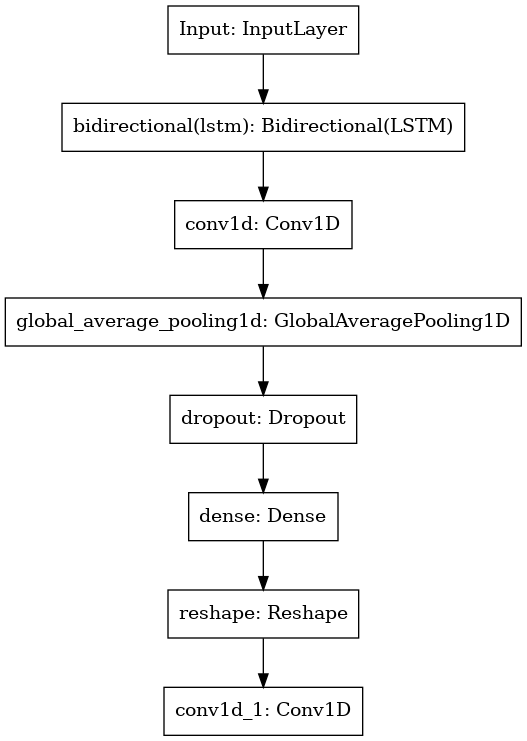

In [18]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [19]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.10,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=8, factor=0.5, min_lr=1e-6)
    ]
).history

2022-01-20 10:22:18.141735: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-01-20 10:22:22.514085: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


188/188 [==============================] - 17s 36ms/step - loss: 0.1130 - mae: 0.2718 - val_loss: 0.0342 - val_mae: 0.1495
Epoch 2/200
188/188 [==============================] - 5s 29ms/step - loss: 0.0193 - mae: 0.1063 - val_loss: 0.0186 - val_mae: 0.0953
Epoch 3/200
188/188 [==============================] - 5s 29ms/step - loss: 0.0150 - mae: 0.0925 - val_loss: 0.0184 - val_mae: 0.0947
Epoch 4/200
188/188 [==============================] - 5s 29ms/step - loss: 0.0138 - mae: 0.0878 - val_loss: 0.0183 - val_mae: 0.0981
Epoch 5/200
188/188 [==============================] - 5s 29ms/step - loss: 0.0130 - mae: 0.0850 - val_loss: 0.0183 - val_mae: 0.0976
Epoch 6/200
188/188 [==============================] - 6s 30ms/step - loss: 0.0126 - mae: 0.0833 - val_loss: 0.0184 - val_mae: 0.0949
Epoch 7/200
188/188 [==============================] - 6s 31ms/step - loss: 0.0121 - mae: 0.0813 - val_loss: 0.0180 - val_mae: 0.0934
Epoch 8/200
188/188 [==============================] - 6s 29ms/step - los

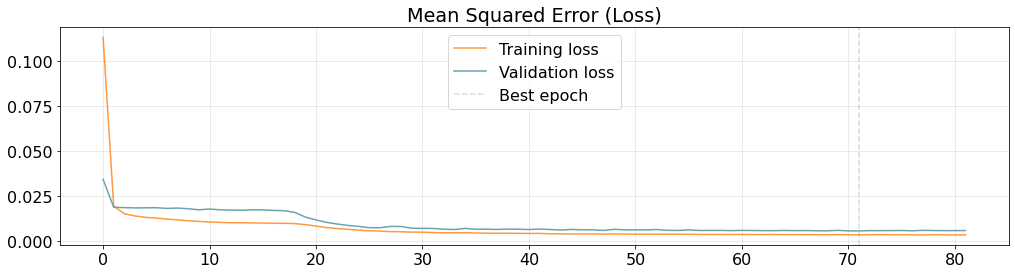

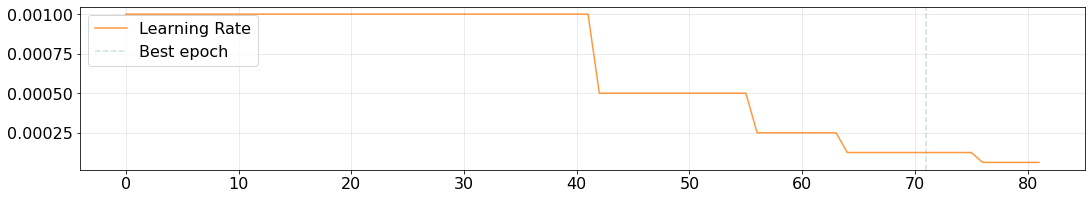

In [20]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [21]:
model.save('AuroregressiveForecasting')
model = tfk.models.load_model('AuroregressiveForecasting')

2022-01-20 10:30:55.155989: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [22]:
#plot forecasting made with telescope size (in this case 27)
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))
        figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
        for i, col in enumerate(columns):
            axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
            axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
            axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
            axs[i].set_title(col)
            axs[i].set_ylim(0,1)
    plt.show()

(158, 24, 7)


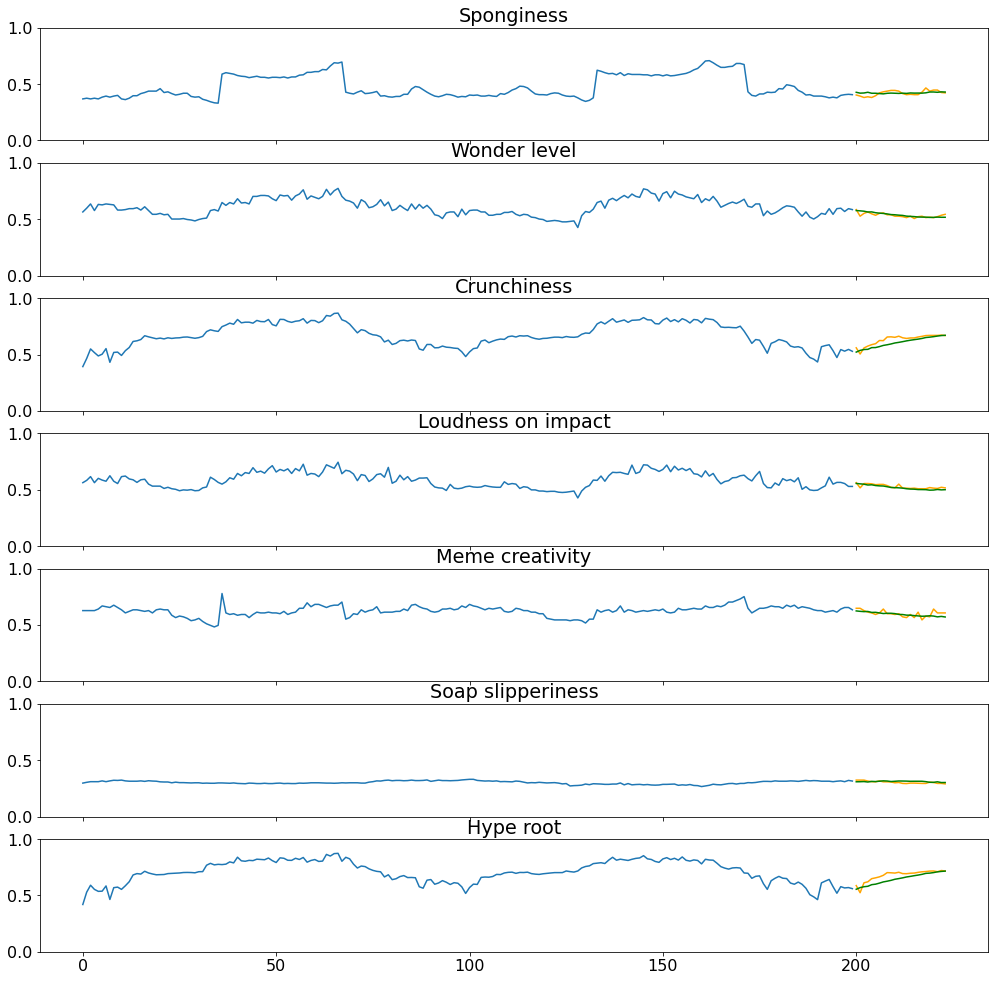

In [23]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)

In [24]:
reg_telescope = 864
X_test_reg, y_test_reg = build_sequences(X_test_raw, target_labels, window, stride, reg_telescope)
X_test_reg.shape, y_test_reg.shape

((74, 200, 7), (74, 864, 7))

In [25]:
# Autoregressive Forecasting
reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(0,reg_telescope,telescope):
    pred_temp = model.predict(X_temp)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,telescope:,:],pred_temp), axis=1)

In [26]:
reg_predictions.shape

(74, 864, 7)

In [27]:
mean_squared_error = tfk.metrics.mse(y_test_reg.flatten(),reg_predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test_reg.flatten(),reg_predictions.flatten())
mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float32, numpy=0.009309794>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.071452536>)

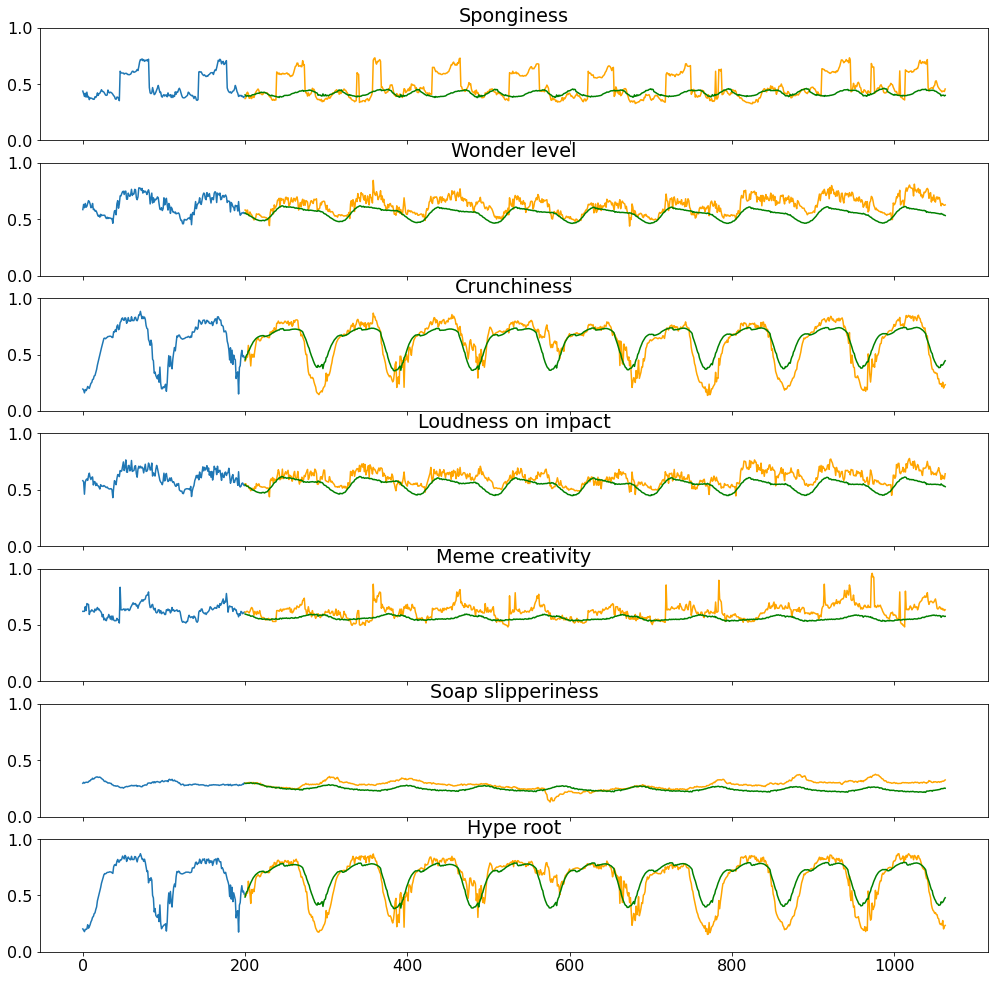

In [28]:
inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, target_labels, reg_telescope)